In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [8]:
# Load data
cov_matrix = pd.read_excel("covariance_matrix.xlsx", index_col=0)
init_values = pd.read_excel("init_values.xlsx", index_col=0)

# Define constants
delta_t = 1 / 52  # Weekly time step
num_simulations = 10000

# Define the mean vector (mu)
mu = np.array([0, 0.07 * delta_t, 0.06 * delta_t] + [0] * (cov_matrix.shape[0] - 3))

# Convert covariance matrix to numpy
Sigma_PnL = cov_matrix.values

# --- Question 1: Expectation and Covariance ---
# Define holding vector (example: equal weights)
h = np.ones(len(mu))  # Equal weights for all assets

# Expectation of Portfolio PnL
E_portfolio_PnL = h.T @ mu

# Variance of Portfolio PnL
Var_portfolio_PnL = h.T @ Sigma_PnL @ h

# Standard deviation (risk) of Portfolio PnL
Std_portfolio_PnL = np.sqrt(Var_portfolio_PnL)

# Print results for Question 1
print("Expectation of Portfolio PnL:", E_portfolio_PnL)
print("Variance of Portfolio PnL:", Var_portfolio_PnL)
print("Standard Deviation (Risk) of Portfolio PnL:", Std_portfolio_PnL)


Expectation of Portfolio PnL: 0.0025000000000000005
Variance of Portfolio PnL: 0.001791753967759466
Standard Deviation (Risk) of Portfolio PnL: 0.04232911489459077


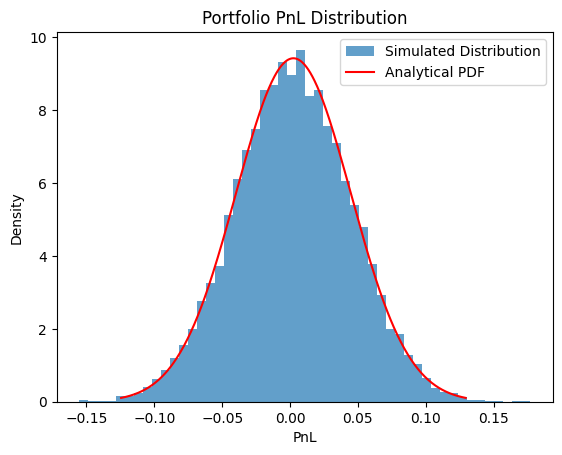

In [9]:
# --- Question 2: Simulating PnL Distribution ---
# Simulate Portfolio PnL
portfolio_pnl = np.random.normal(E_portfolio_PnL, Std_portfolio_PnL, size=num_simulations)

# Plot simulated distribution
plt.hist(portfolio_pnl, bins=50, density=True, alpha=0.7, label="Simulated Distribution")
x = np.linspace(E_portfolio_PnL - 3 * Std_portfolio_PnL, E_portfolio_PnL + 3 * Std_portfolio_PnL, 500)
plt.plot(x, norm.pdf(x, E_portfolio_PnL, Std_portfolio_PnL), 'r-', label="Analytical PDF")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.title("Portfolio PnL Distribution")
plt.legend()
plt.show()

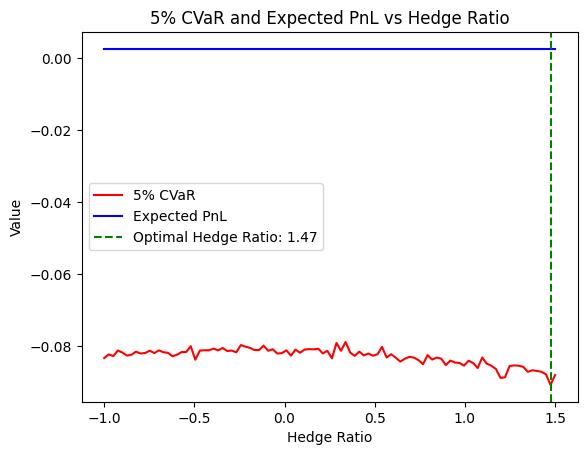

In [10]:
# --- Question 3: CVaR and Hedge Ratio Analysis ---
hedge_ratios = np.linspace(-1, 1.5, 100)
cvar_values = []
expected_pnl_values = []

for h1 in hedge_ratios:
    # Update the holding vector with the hedge ratio
    h = np.ones(len(mu))
    h[0] = h1  # Update the first weight with the hedge ratio

    # Portfolio expectation and variance
    portfolio_mu = h.T @ mu
    portfolio_var = h.T @ Sigma_PnL @ h
    portfolio_std = np.sqrt(portfolio_var)

    # Simulate portfolio PnL
    portfolio_pnl = np.random.normal(portfolio_mu, portfolio_std, size=num_simulations)

    # Calculate 5% CVaR
    cvar_5 = np.mean(np.sort(portfolio_pnl)[:int(0.05 * num_simulations)])
    cvar_values.append(cvar_5)
    expected_pnl_values.append(portfolio_mu)

# Plot 5% CVaR vs Hedge Ratio
plt.plot(hedge_ratios, cvar_values, label="5% CVaR", color='red')
plt.plot(hedge_ratios, expected_pnl_values, label="Expected PnL", color='blue')
optimal_hedge_ratio = hedge_ratios[np.argmin(cvar_values)]
plt.axvline(optimal_hedge_ratio, color='green', linestyle='--', label=f"Optimal Hedge Ratio: {optimal_hedge_ratio:.2f}")
plt.xlabel("Hedge Ratio")
plt.ylabel("Value")
plt.title("5% CVaR and Expected PnL vs Hedge Ratio")
plt.legend()
plt.show()

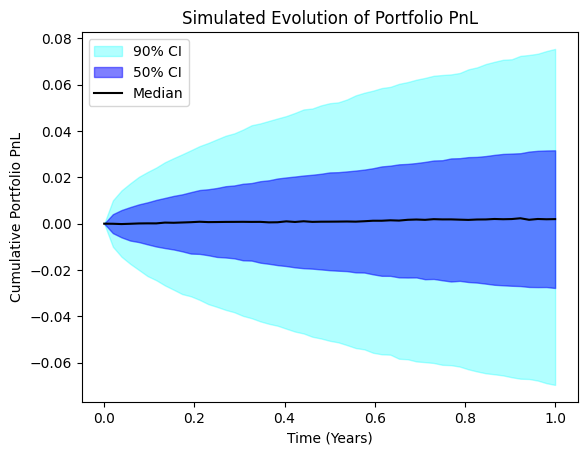

In [11]:
# --- Question 4: Fan Chart for Simulated Portfolio PnL ---
time_steps = 52  # Number of weeks
time_points = np.linspace(0, 1, time_steps + 1)
sim_pnl_paths = []

for _ in range(num_simulations):
    # Simulate weekly PnL increments
    weekly_pnl = np.random.multivariate_normal(mu * delta_t, Sigma_PnL * delta_t, size=time_steps)
    cumulative_pnl = np.cumsum(weekly_pnl @ h)
    sim_pnl_paths.append(np.insert(cumulative_pnl, 0, 0))  # Add initial PnL = 0

sim_pnl_paths = np.array(sim_pnl_paths)

# Calculate percentiles for fan chart
percentiles = np.percentile(sim_pnl_paths, [5, 25, 50, 75, 95], axis=0)

# Plot fan chart
plt.fill_between(time_points, percentiles[0], percentiles[4], color='cyan', alpha=0.3, label="90% CI")
plt.fill_between(time_points, percentiles[1], percentiles[3], color='blue', alpha=0.5, label="50% CI")
plt.plot(time_points, percentiles[2], color='black', label="Median")
plt.xlabel("Time (Years)")
plt.ylabel("Cumulative Portfolio PnL")
plt.title("Simulated Evolution of Portfolio PnL")
plt.legend()
plt.show()
